# 004: Model Interpretability

This notebook dives into model interpretability. Understanding how our model behaves, what the most important features are in our data, and why individual predictions are made

In [150]:
# import packages
import pandas as pd
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import numpy as np
import joblib
import shap
from sklearn.metrics import classification_report

In [151]:
dict_types = {
    'Customer ID': 'category',
    'Age': 'int64',
    'Professional experience': 'int64',
    'Salary': 'int64',
    'ZIP code': 'category',
    'Family size': 'float64',
    'Average credit cards spend': 'float64',
    'Education level': 'category',
    'Mortgage': 'float64',
    'Loan': 'bool',
    'Securities account': 'bool',
    'Certificate of Deposit account': 'bool',
    'Online Banking': 'bool',
    'Credit Card': 'bool'
    }
data = pd.read_csv('../data/preprocessed/preprocessed_data.csv', dtype=dict_types)

In [152]:
data.dtypes

Customer ID                       category
Age                                  int64
Professional experience              int64
Salary                               int64
ZIP code                          category
Family size                        float64
Average credit cards spend         float64
Education level                   category
Mortgage                           float64
Loan                                  bool
Securities account                    bool
Certificate of Deposit account        bool
Online Banking                        bool
Credit Card                           bool
dtype: object

In [153]:
# load the dataset
def load_dataset(full_path):
    dict_types = {
    'Customer ID': 'category',
    'Age': 'int64',
    'Professional experience': 'int64',
    'Salary': 'int64',
    'ZIP code': 'category',
    'Family size': 'float64',
    'Average credit cards spend': 'float64',
    'Education level': 'category',
    'Mortgage': 'float64',
    'Loan': 'bool',
    'Securities account': 'bool',
    'Certificate of Deposit account': 'bool',
    'Online Banking': 'bool',
    'Credit Card': 'bool'
    }
    dataframe = pd.read_csv(full_path, na_values='?', dtype=dict_types)
    dataframe = dataframe.drop(columns=['Customer ID', 'ZIP code'], axis=1)
    y = dataframe['Loan']
    X = dataframe.drop('Loan', axis=1)
    cat_ix = X.select_dtypes(include=['category']).columns
    num_ix = X.select_dtypes(include=['int64', 'float64', 'bool']).columns
    return X, y, cat_ix, num_ix

In [154]:
# load the dataset
X, y, cat_ix, num_ix = load_dataset('../data/preprocessed/preprocessed_data.csv')

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [157]:
pipeline = joblib.load('../models/tuned_pipeline.pkl')

In [158]:
X_train

,Age,Professional experience,Salary,Family size,Average credit cards spend,Education level,Mortgage,Securities account,Certificate of Deposit account,Online Banking,Credit Card
1448,36,11,9000,4.0,200.000000,3.0,0.0,False,False,True,False
2413,45,21,61000,3.0,700.000000,1.0,0.0,True,True,True,True
4382,58,33,45000,4.0,2100.000000,1.0,0.0,False,False,True,True
3007,60,35,119000,2.0,3900.000000,1.0,0.0,True,False,True,False
3609,40,14,28000,4.0,1500.000000,3.0,0.0,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
4426,25,1,113000,4.0,2300.000000,3.0,0.0,False,False,False,True
466,52,28,74000,1.0,2600.000000,2.0,0.0,False,False,True,True
3092,51,27,44000,3.0,1900.000000,2.0,141000.0,False,False,False,False
3772,63,33,52000,4.0,1666.666667,3.0,0.0,False,False,False,False


In [162]:
cols = pipeline[:-1].get_feature_names_out()
transformed = pd.DataFrame(pipeline['t'].transform(X_test), columns=cols)

In [163]:
transformed.shape

(997, 13)

In [164]:
transformed

,num__Age,num__Professional experience,num__Salary,num__Family size,num__Average credit cards spend,num__Mortgage,num__Securities account,num__Certificate of Deposit account,num__Online Banking,num__Credit Card,cat__Education level_1.0,cat__Education level_2.0,cat__Education level_3.0
0,0.509434,0.348837,0.152778,0.50,0.240000,0.170178,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.584906,0.488372,0.351852,1.00,0.200000,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,0.452830,0.325581,0.342593,1.00,0.266667,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.924528,0.860465,0.000000,0.25,0.080000,0.157212,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.547170,0.395349,0.185185,0.75,0.220000,0.000000,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,0.547170,0.418605,0.157407,0.25,0.030000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,1.0
993,0.773585,0.697674,0.212963,0.75,0.170000,0.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0
994,0.849057,0.767442,0.472222,0.75,0.440000,0.427877,0.0,0.0,1.0,0.0,1.0,0.0,0.0
995,0.924528,0.906977,0.703704,0.50,0.210000,0.000000,0.0,0.0,1.0,1.0,1.0,0.0,0.0


## Shap

Shap is a package to investigate model interpretability. https://shap.readthedocs.io/en/latest/index.html

In [165]:
# print the JS visualization code to the notebook
shap.initjs()

In [166]:
model = pipeline[-1]

In [167]:
explainer = shap.TreeExplainer(model)

In [168]:
X_test_trans = pd.DataFrame(pipeline['t'].transform(X_test), columns=cols)

In [169]:
shap_values = explainer.shap_values(X_test_trans)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Let's see what the most important factors are for a customer taking out a loan.

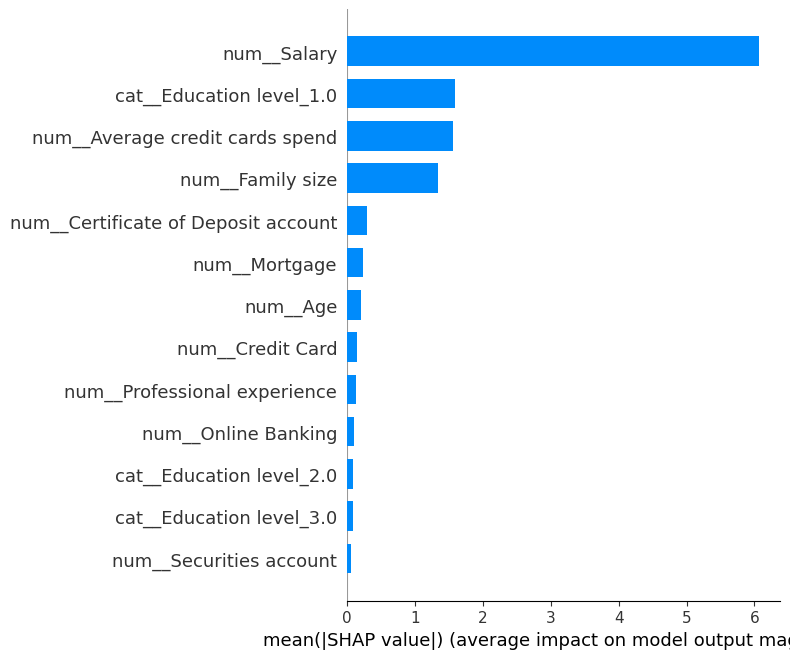

In [172]:
shap.summary_plot(shap_values, X_test_trans, plot_type='bar')

In [176]:
shap.force_plot(explainer.expected_value, shap_values, X_test_trans)

## Using prediction data...

In [196]:
# load the dataset
def load_new_dataset(full_path):
    dict_types = {
    'Customer ID': 'category',
    'Age': 'int64',
    'Professional experience': 'int64',
    'Salary': 'int64',
    'ZIP code': 'category',
    'Family size': 'float64',
    'Average credit cards spend': 'float64',
    'Education level': 'category',
    'Mortgage': 'float64',
    'Loan': 'bool',
    'Securities account': 'bool',
    'Certificate of Deposit account': 'bool',
    'Online Banking': 'bool',
    'Credit Card': 'bool'
    }
    dataframe = pd.read_csv(full_path, na_values='?', usecols = ['Customer ID','Age', 'Professional experience', 'Salary',
    'ZIP code',
    'Family size',
    'Average credit cards spend',
    'Education level',
    'Mortgage',
    'Securities account',
    'Certificate of Deposit account',
    'Online Banking',
    'Credit Card'], dtype=dict_types)
    dataframe = dataframe.drop(columns=['Customer ID', 'ZIP code'], axis=1)
    X = dataframe
    cat_ix = X.select_dtypes(include=['category']).columns
    num_ix = X.select_dtypes(include=['int64', 'float64', 'bool']).columns
    return X, cat_ix, num_ix

In [197]:
X_new, cat_ix, num_ix = load_new_dataset(full_path='../data/predict/predict_data.csv')

In [198]:
X_train_trans = pd.DataFrame(pipeline['t'].transform(X_train), columns=cols)
X_new_trans = pd.DataFrame(pipeline['t'].transform(X_new), columns=cols)

We can now get explainations for individual predictions.

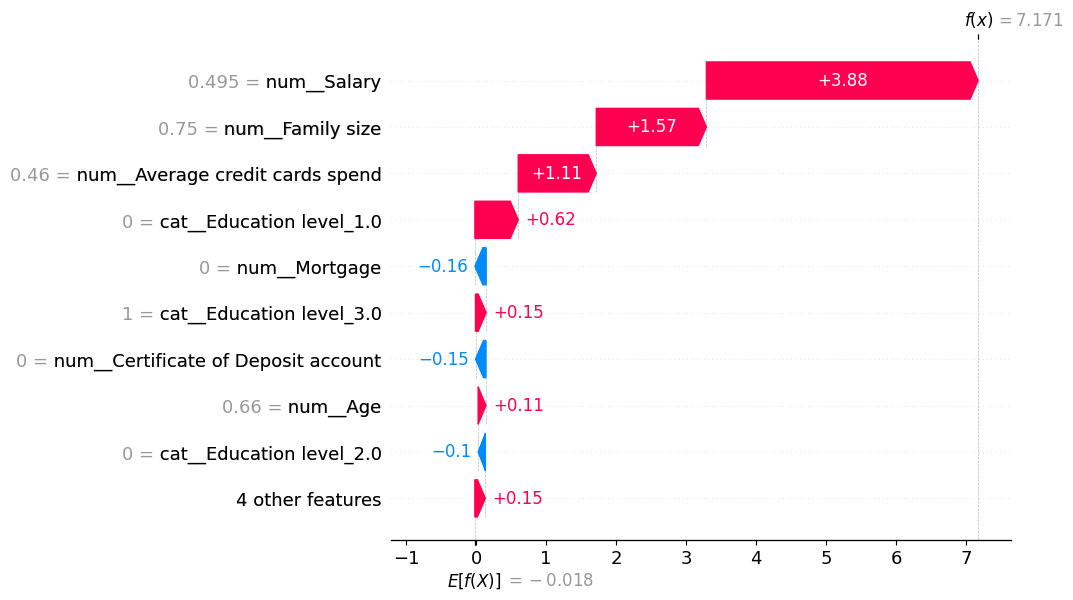

In [238]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X_train_trans)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[22])